Importing Packages

In [1]:
import pandas as pd
import json
# from sklearn.model_selection import train_test_split
from sklearn import cluster
# from sklearn import preprocessing
# from sklearn import tree
from sklearn import metrics
import seaborn
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import sqlalchemy

Fetching tb_products from our database

In [5]:
DB_PATH = r"C:\Users\jpgsa\Documents\GitHub\autodoc-task\autodoc-task-jan-2024\database_files\task_dataset.db"
engine = sqlalchemy.create_engine("sqlite:///" + DB_PATH)
table = "tb_products"

df_products = pd.read_sql_table(table, engine)
df_products.head()

,product_id,sessions_a2b_qty,sessions_with_order,events_a2b_qty,events_pdp_a2b_qty,events_plp_a2b_qty,events_search_plp_a2b_qty,pages_before_a2b_qty,pdp_before_a2b_qty,plp_before_a2b_qty,search_plp_before_a2b_qty
0,26372760,21,12,21,20,0,1,58,38,5,13
1,27133309,20,0,20,20,0,0,20,20,0,0
2,20053168,13,0,13,13,0,0,14,14,0,0
3,31845429,12,2,12,11,0,1,30,25,2,3
4,20283956,11,4,13,10,0,3,62,31,6,25


Creates Model

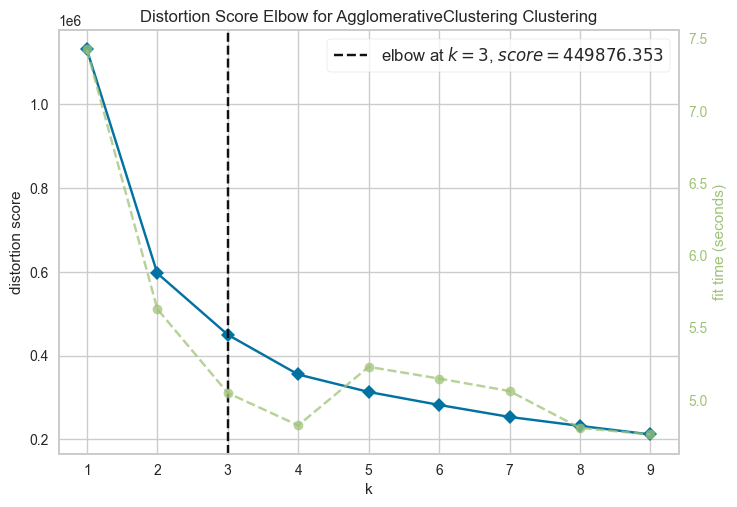

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
features = df_products.columns[1:]
model = cluster.AgglomerativeClustering()

## KElbowVisualizer retrieves the ideal number of clusters
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(df_products[features])
visualizer.show() 

In [11]:
# Now we can use the ideal number of clusters
model = cluster.AgglomerativeClustering(n_clusters=3)
model.fit(df_products[features])

df_products["cluster_id"] = model.labels_
df_products.groupby("cluster_id").count()["product_id"]

cluster_id
0     836
1    2034
2    9571
Name: product_id, dtype: int64

Checking the features heatmap across clusters

<Axes: ylabel='cluster_id'>

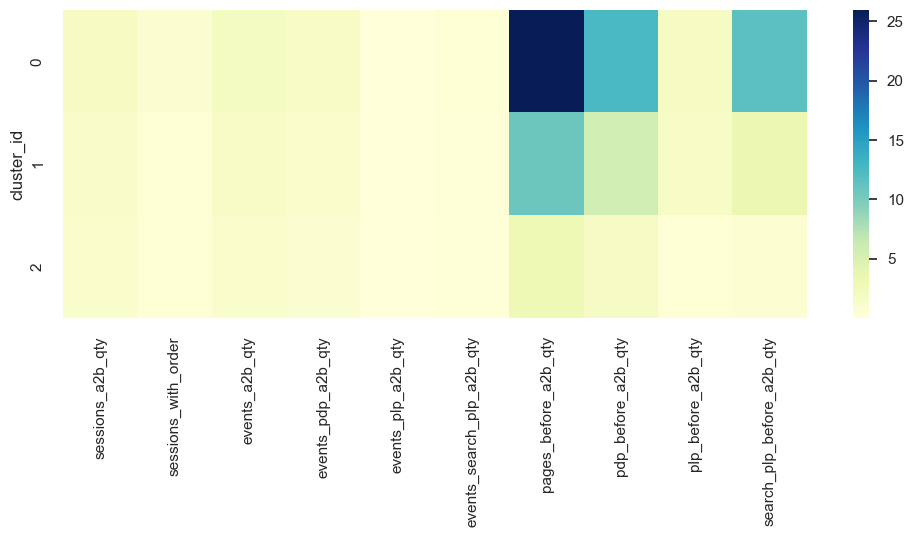

In [49]:
seaborn.set(rc={'figure.figsize':(12,4)})
features_cluster = df_products.columns[1:]
seaborn.heatmap(df_products[features_cluster].groupby("cluster_id").mean(),cmap="YlGnBu")

New approach, we'll only use "pages before atb" as features

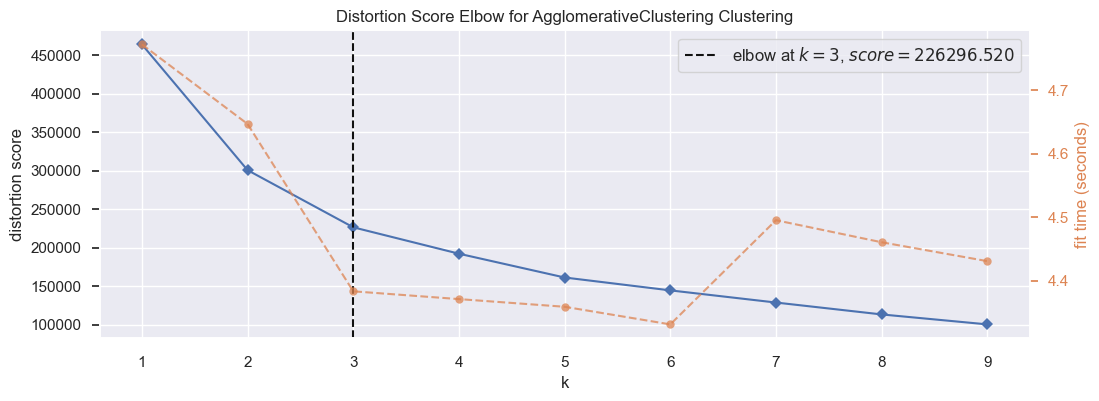

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
new_features = ["pdp_before_a2b_qty",
                "plp_before_a2b_qty",
                "search_plp_before_a2b_qty"]

model = cluster.AgglomerativeClustering()

## KElbowVisualizer retrieves the ideal number of clusters
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(df_products[new_features])
visualizer.show() 

In [67]:
# Now we can use the ideal number of clusters
model = cluster.AgglomerativeClustering(n_clusters=3)
model.fit(df_products[new_features])

df_products["cluster_id_2"] = model.labels_
df_products.groupby("cluster_id_2").count()["product_id"]

cluster_id_2
0     1367
1    10352
2      722
Name: product_id, dtype: int64

Checking the features heatmap across clusters

<Axes: ylabel='cluster_id_2'>

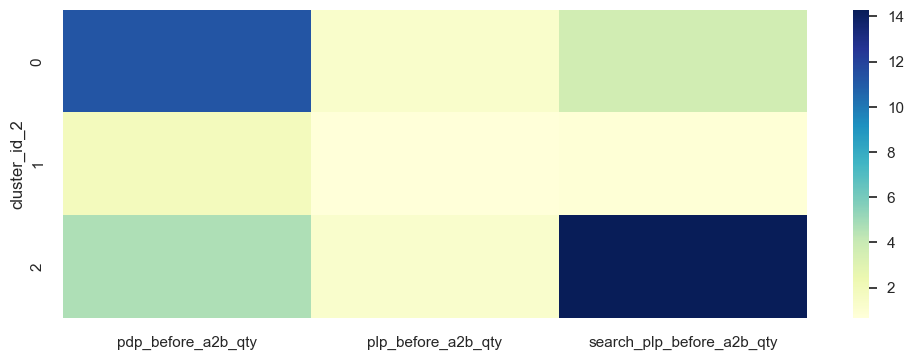

In [68]:
seaborn.set(rc={'figure.figsize':(12,4)})

features_cluster2 = []
for feature in new_features: features_cluster2.append(feature)
features_cluster2.append("cluster_id_2")

seaborn.heatmap(df_products[features_cluster2].groupby("cluster_id_2").mean(),cmap="YlGnBu")

In [74]:
df_products.groupby("cluster_id_2").mean()[new_features + ["pages_before_a2b_qty","sessions_a2b_qty","sessions_with_order"]]

,pdp_before_a2b_qty,plp_before_a2b_qty,search_plp_before_a2b_qty,pages_before_a2b_qty,sessions_a2b_qty,sessions_with_order
cluster_id_2,,,,,,
0,11.246525,1.294806,3.620337,16.167520,1.667886,0.756401
1,1.844861,0.662577,0.773957,3.297044,1.100270,0.450251
2,4.680055,1.236842,14.296399,20.217452,1.292244,0.584488


##### Cluster 0 (1,367 products) // Takes long PDP to PDP navigation until ATC

* 0.76 sessions with order rate (highest)
* takes ~16 pages until ATC, mostly PDP
* We may need to improve finding these products by improving listings & adding recommendations

##### Cluster 1 (10,352 products) // Quick ATC but low conversion
* 0.45 sessions with order (lowest)
* takes ~3 pages until ATC
* We're potentially promoting these products with direct links to PDP but they don't convert as much - we may need to optimize our product seletion for capaigns (remove itens with low performance and include itens from cluster 0)

##### Cluster 2: 722 products 
* ~ 0.59 sessions with order rate (mid)
* takes ~20 pages until ATC, mostly search
* We should get the properties/key words of these itens and improve search engine